In [158]:
import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
processed_series_path = Path(parent_dir) / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

# from models.ICL import MultiResolutionPDF

In [193]:
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    print(f"[{index}]: {file.name}")


[0]: brownian_motion_1.pkl
[1]: brownian_motion_2.pkl
[2]: geometric_brownian_motion_3.pkl
[3]: markov_chain_0.pkl
[4]: markov_chain_1.pkl
[5]: markov_chain_2.pkl
[6]: markov_chain_3.pkl
[7]: markov_chain_4.pkl
[8]: markov_chain_5.pkl
[9]: markov_chain_6.pkl
[10]: markov_chain_7.pkl
[11]: noisy_logistic_map_0.pkl
[12]: noisy_logistic_map_2.pkl
[13]: uncorrelated_gaussian_2.pkl
[14]: uncorrelated_gaussian_3.pkl
[15]: uncorrelated_uniform_1.pkl
[16]: uncorrelated_uniform_3.pkl


In [194]:
alpha = 1
file = all_files[10]
processed_dict = pickle.load(file.open('rb'))
full_array = processed_dict['full_array']
llama_size = processed_dict['llama_size']
random_seed = processed_dict['random_seed']
full_series = processed_dict['full_series']
logit_mat_good = processed_dict['logit_mat_good']
P = processed_dict['P']
llama_size = processed_dict['llama_size']
print(f"random seed: {random_seed}")
print(f"series name: {file.name}")
print(f"llama_size: {llama_size}")

random seed: 1
series name: markov_chain_7.pkl
llama_size: 70b


In [195]:
logit_mat_good.shape

torch.Size([1, 1502, 8])

In [196]:
### tune temperature 
T = 1
probs = torch.nn.functional.softmax(logit_mat_good / T, dim=-1)[:,:,:]


In [197]:
states

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [198]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import torch
T = 1
# Assuming logit_mat, T, good_tokens_str, full_array, and full_series are defined
# ...


full_array_len = len(full_array)
states = np.arange(logit_mat_good.shape[-1])
width = 0.4

def digiprob_plotter(digit_idx=-2):
    
    fig, axs = plt.subplots(2, 1, figsize = (12,6))
    
    # Add distance between the two main plots
    plt.subplots_adjust(hspace=0.4)  # Adjust the horizontal space between subplots
    
    axs[0].plot(full_array, marker='o', ls = 'none')
    preceding_state = full_array[digit_idx]
    axs[0].plot(digit_idx, preceding_state, color='r', marker='o')
    
    probs_array = probs[0, digit_idx,:].cpu().numpy()
    axs[1].set_title(full_series[-30 + digit_idx + 1:digit_idx + 1] + "?")
    
    # Create the bars, shifting the x position for one set
    print(probs_array.shape)
    axs[1].bar(states + width/2, probs_array, width, alpha=0.5, color='b', label="LLM prediction")
    axs[1].bar(states - width/2, P[preceding_state], width, alpha=0.5, color='r', label="True transition")

    # Set other plot properties
    axs[1].set_ylim(0, 1)
    axs[1].set_xlabel("Digit")
    axs[1].set_ylabel("Probability")
    axs[1].set_xticks(states)

    # Show legend
    axs[1].legend()

    # Show the plot
    plt.show()

interact(digiprob_plotter, digit_idx=(1, full_array_len-1, 1))

interactive(children=(IntSlider(value=1, description='digit_idx', max=1499, min=1), Output()), _dom_classes=('…

<function __main__.digiprob_plotter(digit_idx=-2)>

In [199]:
probs

tensor([[[0.0993, 0.2349, 0.2259,  ..., 0.1072, 0.0455, 0.0423],
         [0.0387, 0.3445, 0.2725,  ..., 0.0838, 0.0466, 0.0481],
         [0.1149, 0.2096, 0.1375,  ..., 0.1046, 0.0881, 0.1046],
         ...,
         [0.2139, 0.2540, 0.0492,  ..., 0.1718, 0.0739, 0.1403],
         [0.1991, 0.1625, 0.1049,  ..., 0.1066, 0.1286, 0.0956],
         [0.2141, 0.2351, 0.0415,  ..., 0.2011, 0.0706, 0.1542]]])

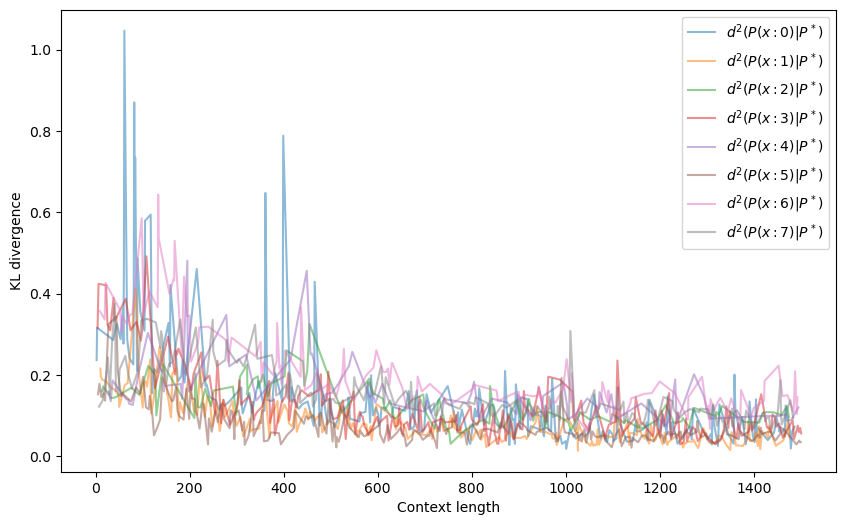

In [200]:
dist_type = "KL"
start_idx = 0

# dist_type = "BH"
### Weighted KL divergence
plt.figure(figsize=(10,6))
loss_array = np.zeros(full_array[start_idx:].squeeze().shape)
# for state in states[[0,1]]:
for state in states:
    ### add 2 to slice out BOS
    pos = np.where(full_array[start_idx:]==state)[0]+2
    learned_p_out = probs.squeeze()[start_idx:][pos]
    true_p_out = torch.tensor(P[state])
    if dist_type == 'KL':
    ### KL divergence at each row
        KL = torch.sum(true_p_out * (true_p_out.log() - learned_p_out.log()), dim = 1)
        dist = KL
    else:
        ### Bhattacharyya distance at each row
        sqrt_PQ = torch.sum(torch.sqrt(learned_p_out * true_p_out), dim = 1)
        BH_dist = -torch.log(sqrt_PQ)
        dist = BH_dist
    
    loss_array[pos-2] = dist.numpy()
    plt.plot(pos, dist, label = f"$d^2(P(x:{state})| P^*)$", alpha = 0.5)

    # plt.loglog()
    plt.xlabel("Context length")
    plt.ylabel("KL divergence")
    plt.legend()
# plt.loglog()


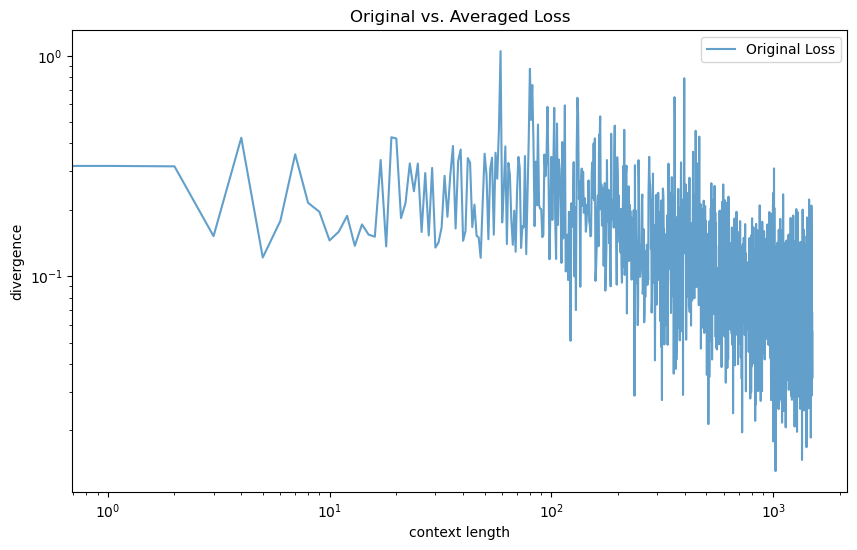

In [201]:
# Define a top-hat kernel for averaging
window_size = 20
top_hat_kernel = np.ones(window_size) / window_size

# Convolve the loss_array with the top-hat kernel
averaged_loss = np.convolve(loss_array, top_hat_kernel, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(loss_array, label="Original Loss", alpha=0.7)
# plt.plot(np.arange(window_size//2, len(loss_array) - window_size//2 + 1), averaged_loss, label="Averaged Loss", linewidth=2)
plt.ylabel('divergence')
plt.xlabel("context length")
plt.loglog()
plt.legend()
plt.title("Original vs. Averaged Loss")
plt.show()